In [1]:
import os
import random
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import open3d as o3d

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

%env CUDA_VISIBLE_DEVICES=3
import torch
torch.no_grad()
print("cuda available: " + str(torch.cuda.is_available()))

import cuml
from torchvision.utils import save_image, make_grid

from draw import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
env: CUDA_VISIBLE_DEVICES=3
cuda available: True


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
plt.rcParams.update({'font.size': 15})

## Set directories
1. summary file path: summary_name
2. path to save images: save_dir

In [3]:
save_dir = 'images'
experiment_name = 'syn_sadefeldman_beta1_noised_std0.73_geneinputs'
summary_name = os.path.join('/data/rna_rep_learning/scset/checkpoints/', experiment_name, 'summary.pth')

imgdir = os.path.join(save_dir, experiment_name)
imgdir_gt = os.path.join(imgdir, 'gt')
imgdir_recon = os.path.join(imgdir, 'recon')
imgdir_gen = os.path.join(imgdir, 'gen')

os.makedirs(save_dir, exist_ok=True)
os.makedirs(imgdir_gt, exist_ok=True)
os.makedirs(imgdir_recon, exist_ok=True)
os.makedirs(imgdir_gen, exist_ok=True)

In [4]:
summary_name

'/data/rna_rep_learning/scset/checkpoints/syn_sadefeldman_beta1_noised_std0.73_geneinputs/summary.pth'

In [5]:
summary = torch.load(summary_name)
for k, v in summary.items():
    try:
        print(f"{k}: {v.shape}")
    except AttributeError:
        print(f"{k}: {len(v)}")

smp_set: torch.Size([120, 700, 3937])
smp_mask: torch.Size([120, 700])
smp_att: 3
priors: 4
recon_set: torch.Size([120, 700, 3937])
recon_mask: torch.Size([120, 700])
posteriors: 4
dec_att: 3
enc_att: 3
enc_hiddens: 12
init_set: torch.Size([120, 700, 64])
dec_hiddens: 12
dec_latents: 12
gt_set: torch.Size([120, 403, 3937])
gt_mask: torch.Size([120, 403])
mean: torch.Size([12])
std: torch.Size([12])
sid: 12
mid: 12
pid: 12
cardinality: 12


## Select the samples to visualize
- parse the samples by index.
- below default code will visualize all samples. **Warning: Requires Huge Memory**

In [6]:
recon_targets = list(range(len(summary['gt_mask'])))[:]
gen_targets = list(range(len(summary['smp_mask'])))[:]

len_att = len(summary['dec_att'])
gt = summary['gt_set'][recon_targets]
gt_mask = summary['gt_mask'][recon_targets]

recon = summary['recon_set'][recon_targets]
recon_mask = summary['recon_mask'][recon_targets]

dec_att = [summary['dec_att'][l][:, :, recon_targets] for l in range(len_att)]
enc_att = [summary['enc_att'][l][:, :, recon_targets] for l in range(len_att)]

gen = summary['smp_set'][gen_targets]
gen_mask = summary['smp_mask'][gen_targets]
gen_att = [summary['smp_att'][l][:, :, gen_targets] for l in range(len_att)]

# Collate data across all samples. run UMAP, and viz

inputs were of size 350 cells each; it reconstructed (and generated) samples of 700 cells each
I thought that reconstruction should be set to have the same cardinality as gt?

In [7]:
print(gt.shape)
print(recon.shape)

torch.Size([120, 403, 3937])
torch.Size([120, 700, 3937])


In [8]:
gt_adata = sc.read_h5ad("/localdata/rna_rep_learning/sadefeldman/synthetic_data/syn_adata_noised_std_0.7261.h5ad")


In [13]:
gt_adata.var.columns = [s.replace("_orig_orig_orig_orig_orig","_orig") for s in gt_adata.var.columns]

In [41]:
recon_adata = sc.AnnData(recon.reshape(-1,recon.shape[2])[~recon_mask.reshape(-1),:].numpy(), var = gt_adata.var.loc[gt_adata.var.highly_variable, ['n_cells_orig','highly_variable_orig','means_orig','mean_orig','std_orig']]) #only take unmasked outputs!!!



In [42]:
recon_adata

AnnData object with n_obs × n_vars = 40862 × 3937
    var: 'n_cells_orig', 'highly_variable_orig', 'means_orig', 'mean_orig', 'std_orig'

#### calculate PCA, neighbors & UMAP for reconstructed cells

In [43]:
#adata.raw = adata
recon_adata.layers['lognorm'] = recon_adata.X.copy()

In [44]:
sc.pp.scale(recon_adata, max_value=10) #also time consuming

In [45]:
sc.tl.pca(recon_adata, svd_solver='arpack', use_highly_variable=False) #also time consuming


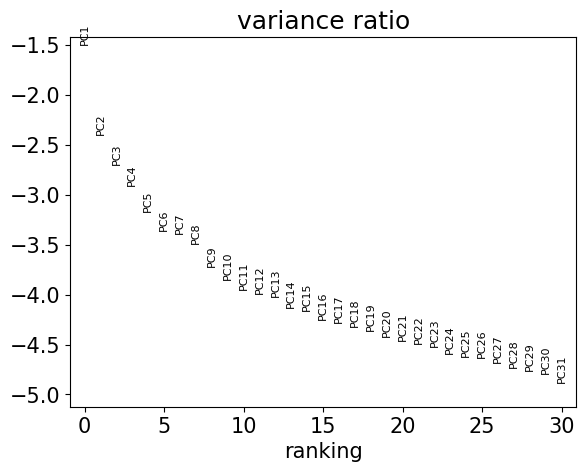

In [46]:
sc.pl.pca_variance_ratio(recon_adata, log=True)

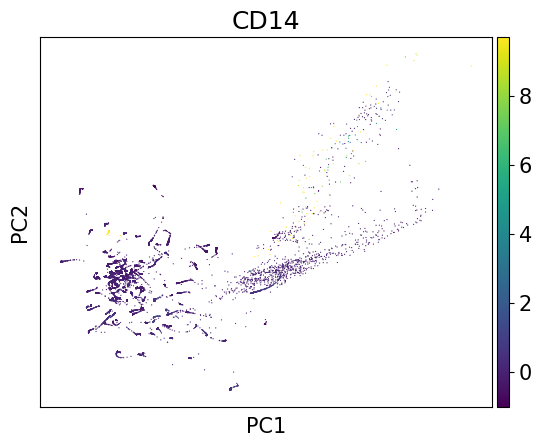

In [47]:
sc.pl.pca(recon_adata, color=['CD14'])

In [48]:
sc.pp.neighbors(recon_adata, n_neighbors=30, n_pcs=20)

In [49]:
sc.tl.umap(recon_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [50]:
recon_adata.obs['pid'] = np.repeat(np.array(summary['pid']).reshape(-1), (~recon_mask).sum(axis=1))

In [51]:
#got an error with cmap so manually assigning colors to pids
recon_adata.uns['pid_colors'] = [matplotlib.colors.to_hex(matplotlib.cm.get_cmap('tab20')(i)) for i in np.linspace(0.0, 1.0, len(np.array(summary['pid']).reshape(-1)))]

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


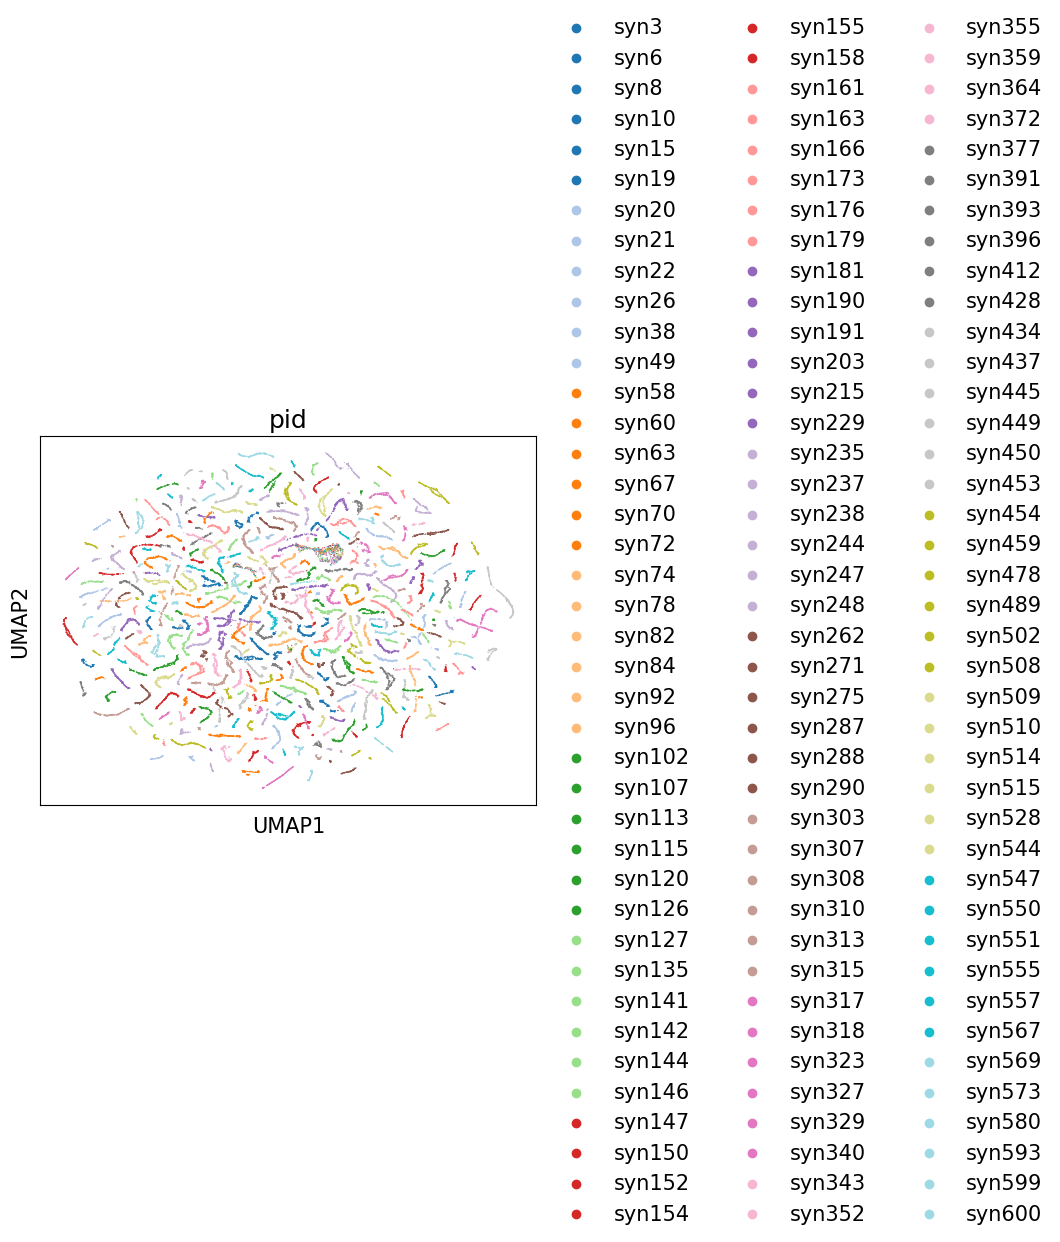

In [52]:
sc.pl.umap(recon_adata, color='pid')

In [53]:
#add PCs to obs in order to color by them
recon_adata.obs = pd.concat([recon_adata.obs, pd.DataFrame(recon_adata.obsm['X_pca'], index=recon_adata.obs.index, columns=["PC"+str(i) for i in range(1,recon_adata.obsm['X_pca'].shape[1]+1)])], axis=1)



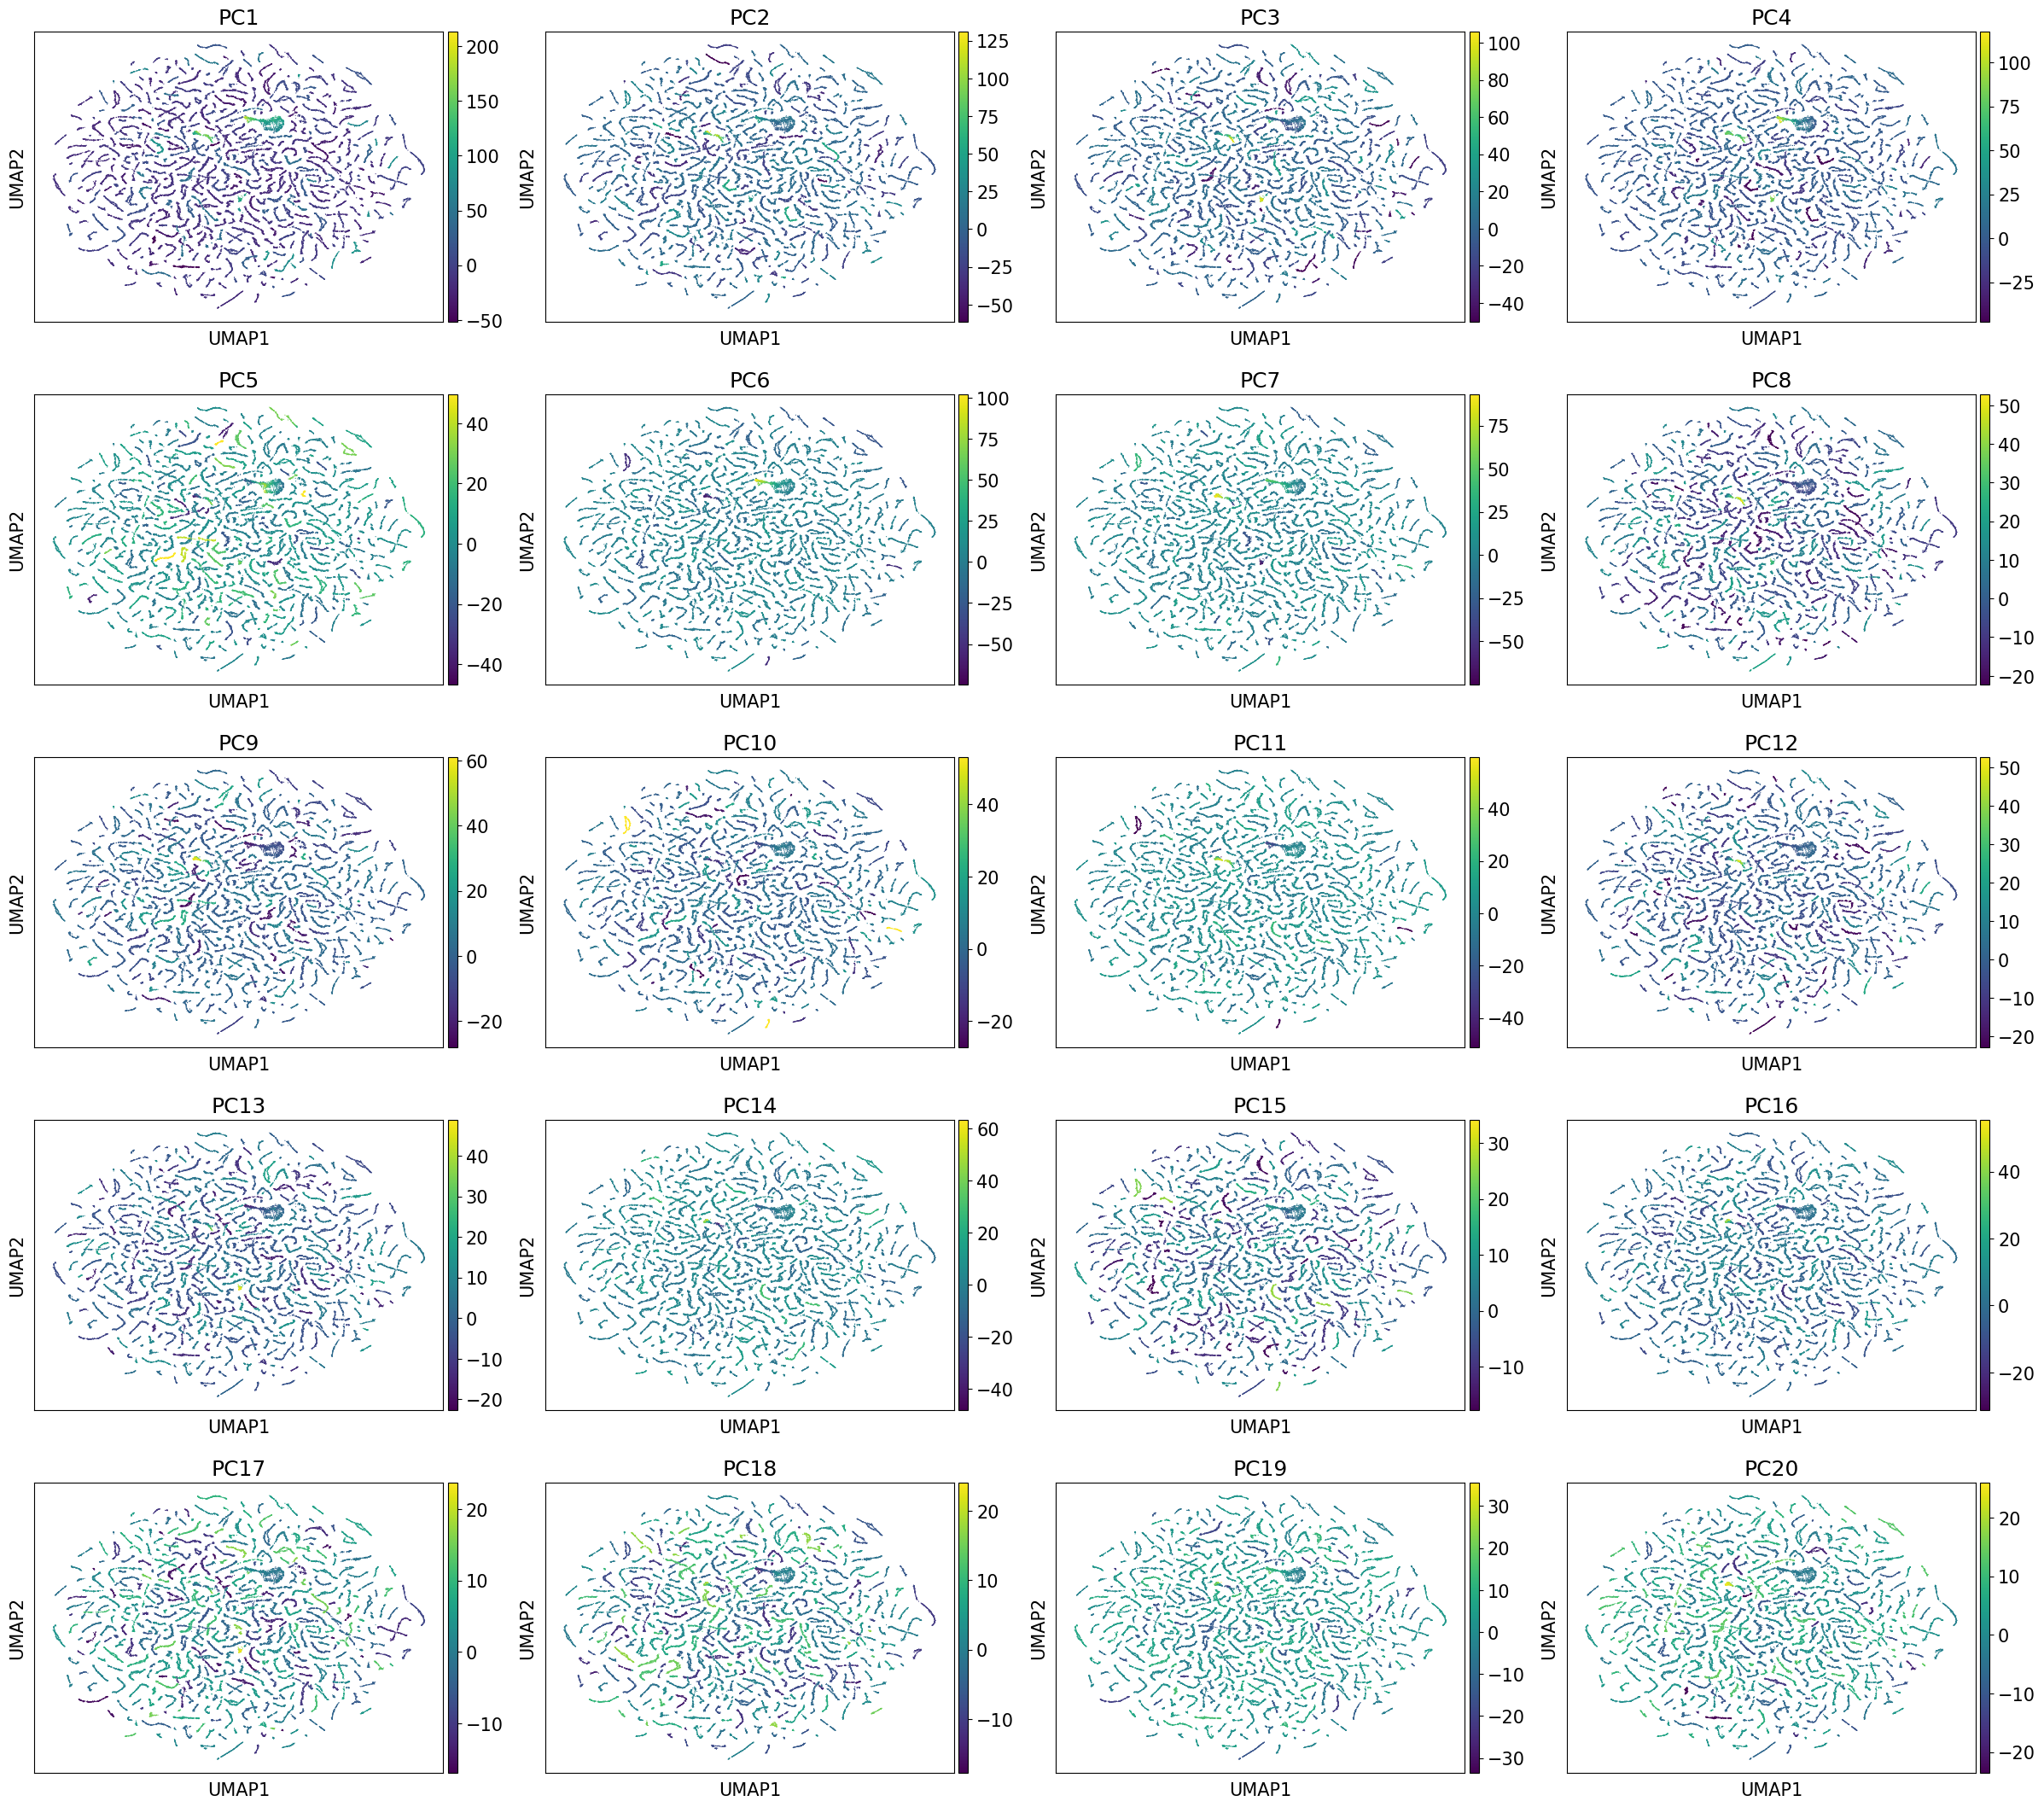

In [54]:
sc.pl.umap(recon_adata, color=["PC"+str(i) for i in range(1,21)])